In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('UberDataset.csv')
df.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


In [3]:
def check(df):
 l=[]
 columns=df.columns
 for col in columns:
  dtypes=df[col].dtypes
  nunique=df[col].nunique()
  sum_null=df[col].isnull().sum()
  l.append([col,dtypes,nunique,sum_null])
 df_check=pd.DataFrame(l)
 df_check.columns=['column','dtypes','nunique','sum_null']
 return df_check
check(df)

,column,dtypes,nunique,sum_null
0,START_DATE,object,1155,0
1,END_DATE,object,1154,1
2,CATEGORY,object,2,1
3,START,object,177,1
4,STOP,object,188,1
5,MILES,float64,257,0
6,PURPOSE,object,10,503


In [5]:
df['PURPOSE'] = df['PURPOSE'].fillna("UNKNOWN")
df.dropna(inplace = True)

df.isnull().sum()

START_DATE    0
END_DATE      0
CATEGORY      0
START         0
STOP          0
MILES         0
PURPOSE       0
dtype: int64

In [6]:
df.describe()

,MILES
count,1155.000000
mean,10.566840
std,21.579106
min,0.500000
25%,2.900000
50%,6.000000
75%,10.400000
max,310.300000


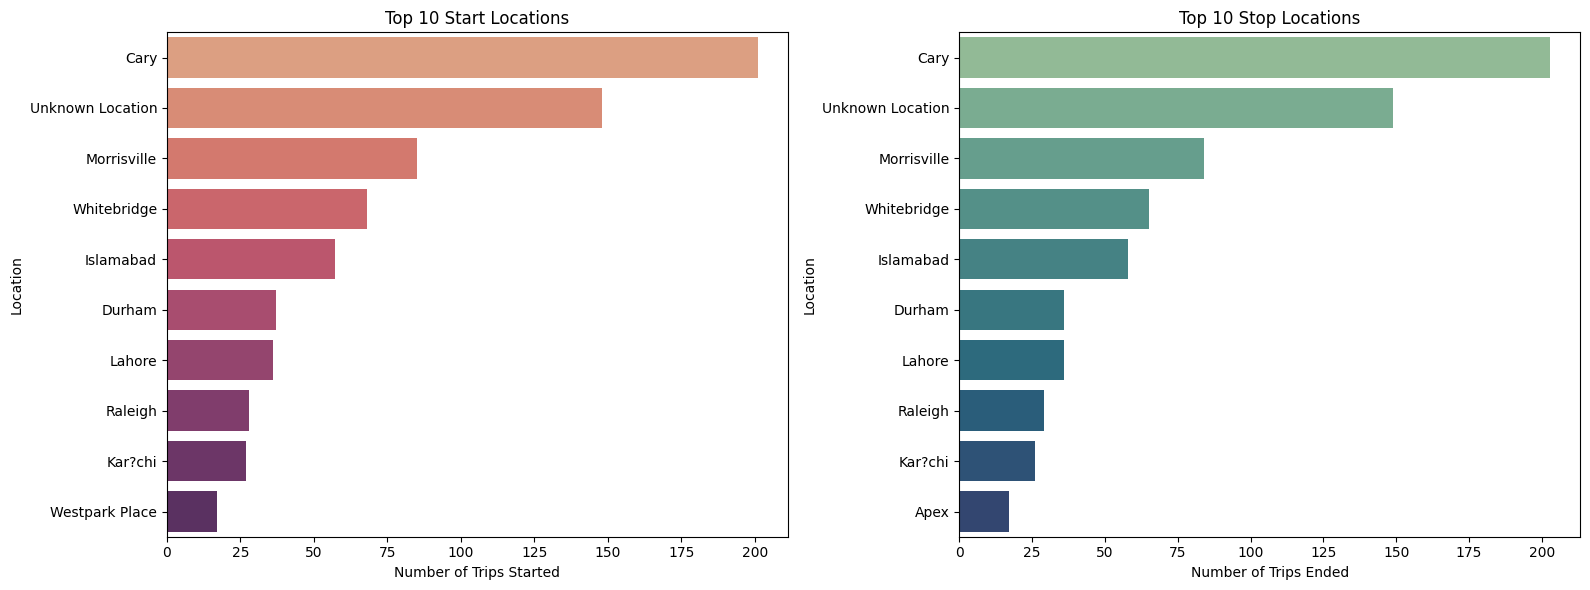

In [13]:
# First, we find the busiest start and stop locations
busiest_start_location = df['START'].value_counts().idxmax()
busiest_stop_location = df['STOP'].value_counts().idxmax()

# Now let's visualize the number of trips starting from the busiest location
# and the number of trips ending at the busiest stop location

# Count the number of trips for each start location
start_location_counts = df['START'].value_counts().reset_index()
start_location_counts.columns = ['Location', 'Number of Starts']

# Count the number of trips for each stop location
stop_location_counts = df['STOP'].value_counts().reset_index()
stop_location_counts.columns = ['Location', 'Number of Stops']

# Plotting
plt.figure(figsize=(16, 6))

# Plot for start locations
plt.subplot(1, 2, 1)
sns.barplot(x='Number of Starts', y='Location', data=start_location_counts.head(10), palette='flare')
plt.title('Top 10 Start Locations')
plt.xlabel('Number of Trips Started')
plt.ylabel('Location')

# Plot for stop locations
plt.subplot(1, 2, 2)
sns.barplot(x='Number of Stops', y='Location', data=stop_location_counts.head(10), palette='crest')
plt.title('Top 10 Stop Locations')
plt.xlabel('Number of Trips Ended')
plt.ylabel('Location')

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='%m-%d-%Y %H:%M', errors='coerce')
df['END_DATE'] = pd.to_datetime(df['END_DATE'], format='%m-%d-%Y %H:%M', errors='coerce')

In [16]:
df['Request Hour'] = df['START_DATE'].dt.hour

In [17]:
TIME_SLOTS = {
    0: 'Late Night',
    1: 'Midnight',
    2: 'Midnight',
    3: 'Early Morning',
    4: 'Early Morning',
    5: 'Early Morning',
    6: 'Morning',
    7: 'Morning',
    8: 'Morning',
    9: 'Morning',
    10: 'Morning',
    11: 'Morning',
    12: 'After Noon',
    13: 'After Noon',
    14: 'After Noon',
    15: 'After Noon',
    16: 'Evening',
    17: 'Evening',
    18: 'Evening',
    19: 'Night',
    20: 'Night',
    21: 'Night',
    22: 'Late Night',
    23: 'Late Night',
}

df['Time Slot'] = df['Request Hour'].apply(lambda x: TIME_SLOTS.get(x))

In [18]:
df.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE,Request Hour,Time Slot
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,21.0,Night
1,2016-01-02 01:25:00,2016-01-02 01:37:00,Business,Fort Pierce,Fort Pierce,5.0,UNKNOWN,1.0,Midnight
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,20.0,Night
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Business,Fort Pierce,Fort Pierce,4.7,Meeting,17.0,Evening
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,14.0,After Noon


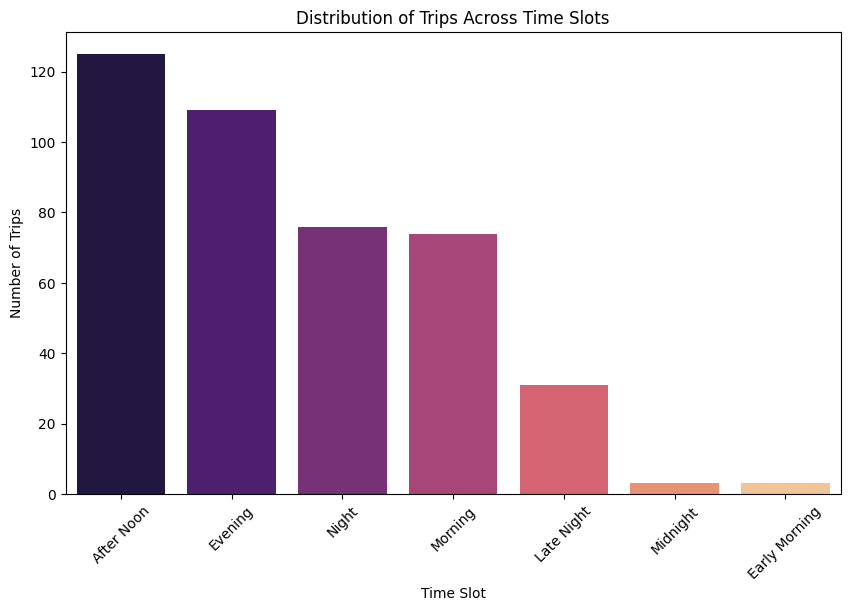

In [21]:
time_slot_counts = df['Time Slot'].value_counts()

# Visualization: Distribution of Trips in Different Time Slots
plt.figure(figsize=(10, 6))
sns.barplot(x=time_slot_counts.index, y=time_slot_counts.values,palette='magma')
plt.title('Distribution of Trips Across Time Slots')
plt.xlabel('Time Slot')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()

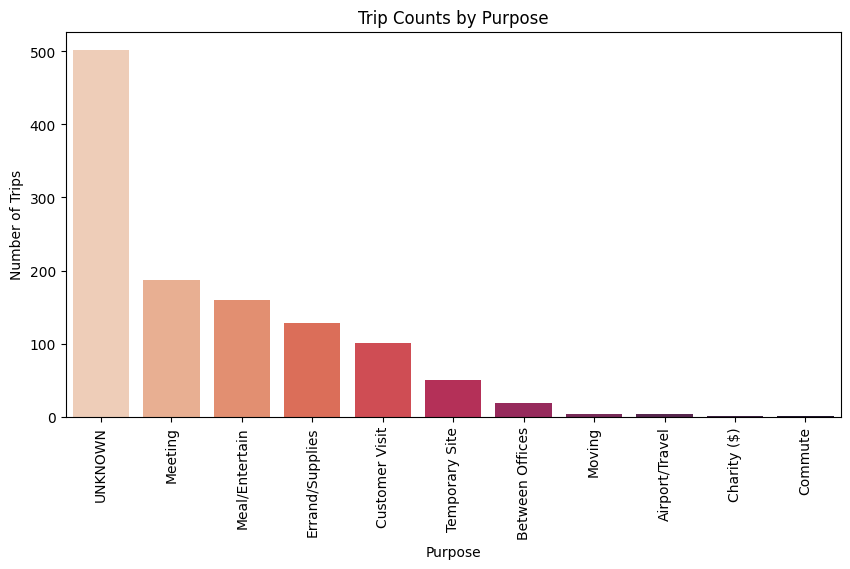

In [24]:
purpose_counts = df['PURPOSE'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=purpose_counts.index, y=purpose_counts.values,palette='rocket_r')
plt.title('Trip Counts by Purpose')
plt.xlabel('Purpose')
plt.ylabel('Number of Trips')
plt.xticks(rotation=90)
plt.show()


Uber Trip Mileage Trends by Purpose and Time of Day

In [27]:
def map_time_slot(hour):

    if 5 <= hour < 12:

        return 'Morning'

    elif 12 <= hour < 17:

        return 'After Noon'

    elif 17 <= hour < 21:

        return 'Evening'

    elif 21 <= hour < 24:

        return 'Night'

    elif 0 <= hour < 5:

        return 'Late Night'
df['Time Slot'] = df['Request Hour'].apply(map_time_slot)

pivot_table = df.pivot_table(index='Time Slot', columns='PURPOSE', values='MILES', aggfunc='sum', fill_value=0)


In [28]:
pivot_table

PURPOSE,Between Offices,Customer Visit,Errand/Supplies,Meal/Entertain,Meeting,Temporary Site,UNKNOWN
Time Slot,,,,,,,
After Noon,62.8,426.0,85.1,131.7,343.1,26.4,281.4
Evening,19.4,260.5,68.1,86.6,120.0,36.3,521.2
Late Night,0.0,0.0,7.4,14.3,214.5,0.0,5.0
Morning,12.2,136.5,20.2,28.5,148.2,45.9,266.7
Night,4.0,34.4,12.9,53.3,293.8,0.0,57.5


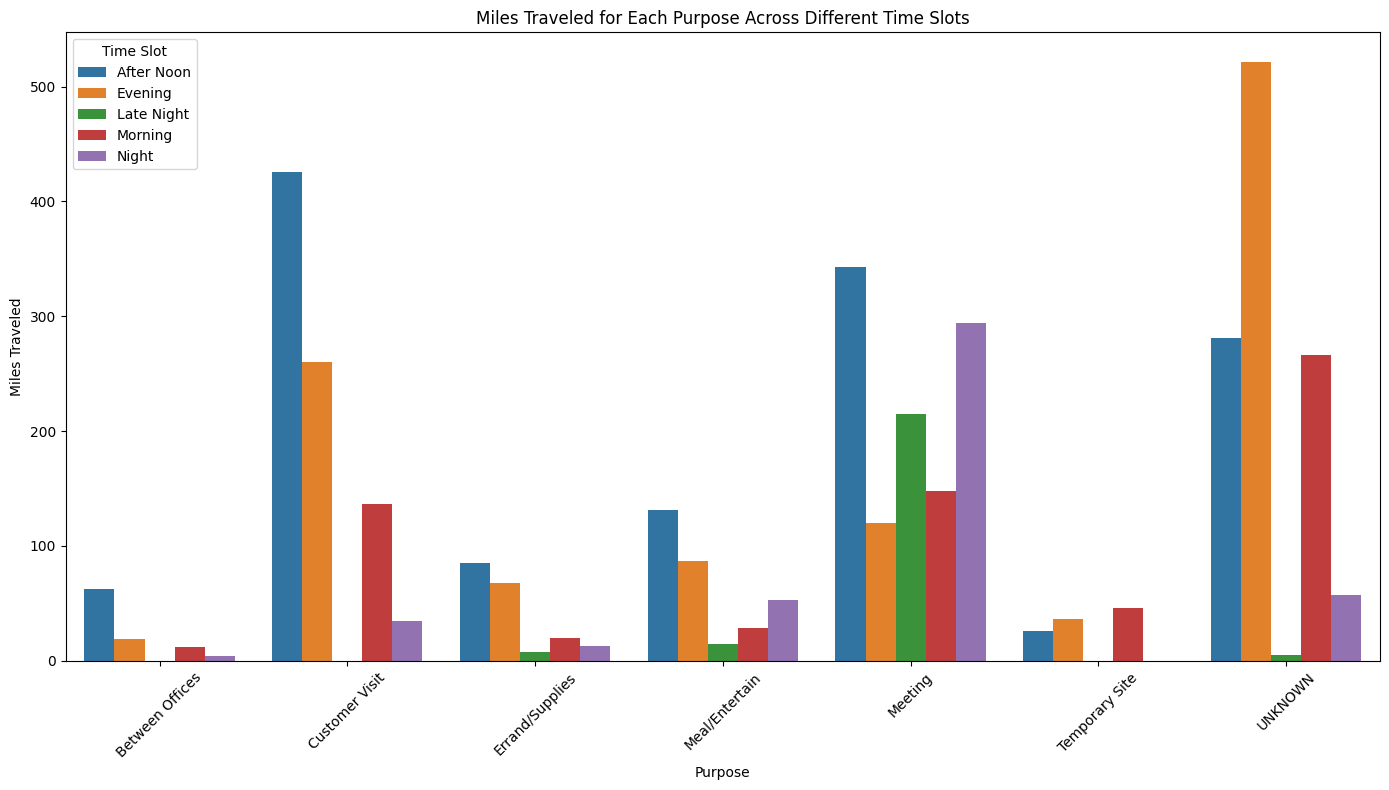

In [30]:
df_pivot = pd.DataFrame(pivot_table)

df_melted = df_pivot.reset_index().melt(id_vars='Time Slot', var_name='Purpose', value_name='Miles')

plt.figure(figsize=(14, 8))
sns.barplot(x='Purpose', y='Miles', hue='Time Slot', data=df_melted)
plt.title('Miles Traveled for Each Purpose Across Different Time Slots')
plt.xticks(rotation=45)
plt.xlabel('Purpose')
plt.ylabel('Miles Traveled')
plt.legend(title='Time Slot')

plt.tight_layout()
plt.show()

Histogram of Trip Miles:

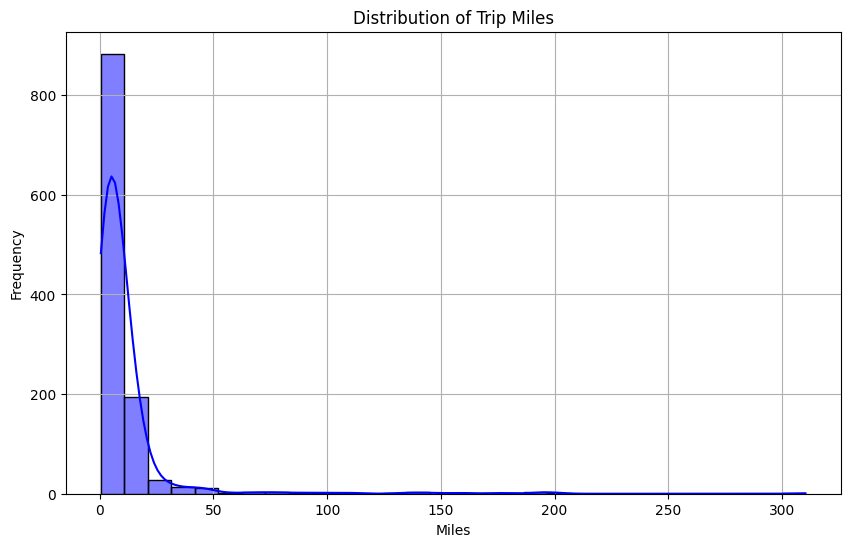

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(df['MILES'], bins=30, kde=True, color='blue')
plt.title('Distribution of Trip Miles')
plt.xlabel('Miles')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Comparative Overview of Trip Lengths for Business and Personal Categories

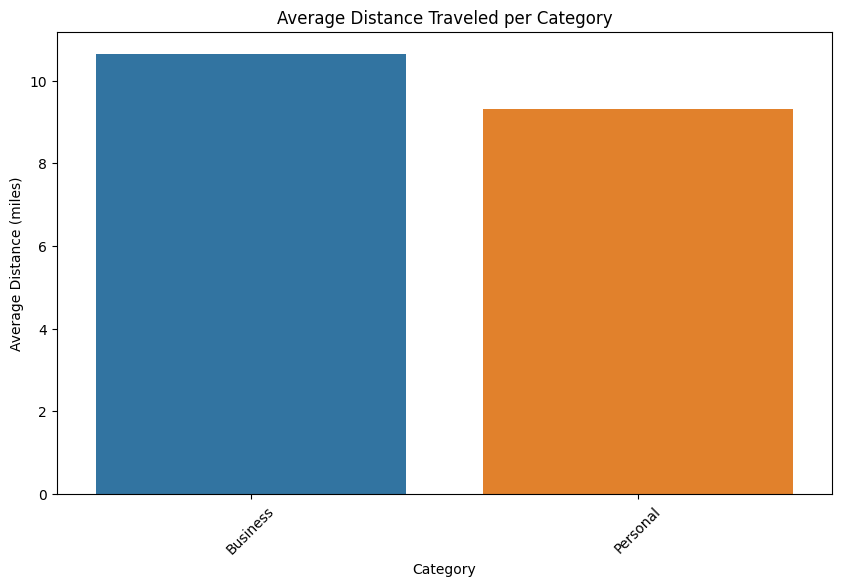

In [32]:
avg_distance_per_category = df.groupby('CATEGORY')['MILES'].mean()

# Convert the Series to DataFrame for plotting
avg_distance_per_category_df = avg_distance_per_category.reset_index()

# Plotting the average distance per category
plt.figure(figsize=(10, 6))
sns.barplot(x='CATEGORY', y='MILES', data=avg_distance_per_category_df)
plt.title('Average Distance Traveled per Category')
plt.xlabel('Category')
plt.ylabel('Average Distance (miles)')
plt.xticks(rotation=45)

plt.show()


Scatter Plot of Time of Day vs. Miles Traveled:

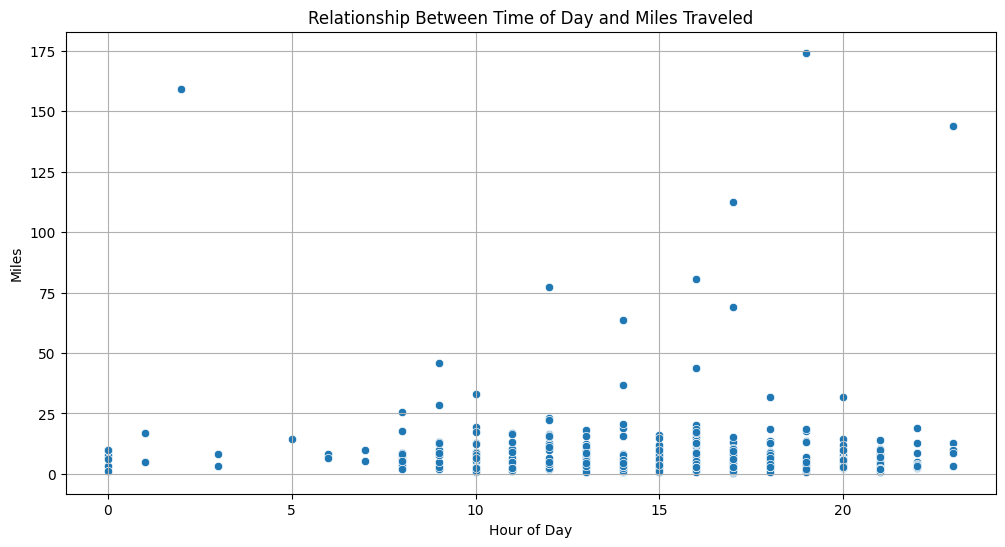

In [33]:
df['Hour_of_Day'] = df['START_DATE'].dt.hour
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Hour_of_Day', y='MILES')
plt.title('Relationship Between Time of Day and Miles Traveled')
plt.xlabel('Hour of Day')
plt.ylabel('Miles')
plt.grid(True)
plt.show()

Uber Trip Trends Over the Year

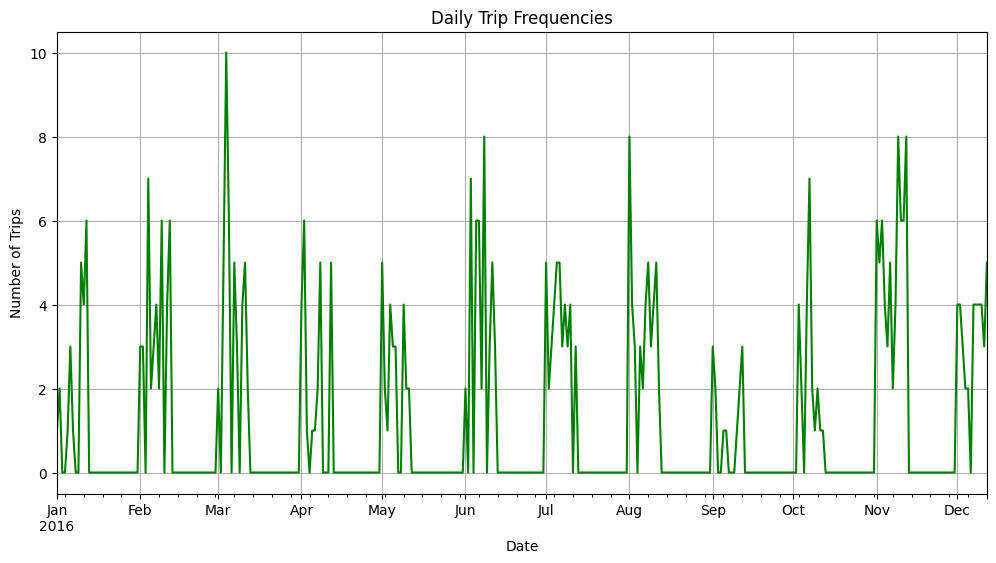

In [34]:
daily_trips = df.resample('D', on='START_DATE').size()
plt.figure(figsize=(12, 6))
daily_trips.plot(title='Daily Trip Frequencies', color='green')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

Histogram of Uber Trip Durations

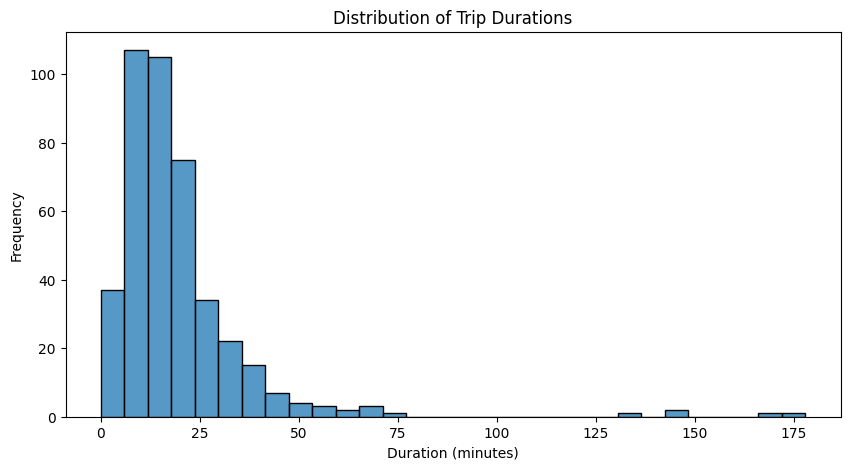

In [35]:
df['DURATION'] = (df['END_DATE'] - df['START_DATE']).dt.total_seconds() / 60

plt.figure(figsize=(10, 5))
sns.histplot(df['DURATION'], bins=30)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

In [36]:
df.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE,Request Hour,Time Slot,Hour_of_Day,DURATION
0,2016-01-01 21:11:00,2016-01-01 21:17:00,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain,21.0,Night,21.0,6.0
1,2016-01-02 01:25:00,2016-01-02 01:37:00,Business,Fort Pierce,Fort Pierce,5.0,UNKNOWN,1.0,Late Night,1.0,12.0
2,2016-01-02 20:25:00,2016-01-02 20:38:00,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies,20.0,Evening,20.0,13.0
3,2016-01-05 17:31:00,2016-01-05 17:45:00,Business,Fort Pierce,Fort Pierce,4.7,Meeting,17.0,Evening,17.0,14.0
4,2016-01-06 14:42:00,2016-01-06 15:49:00,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit,14.0,After Noon,14.0,67.0


Classification Model for Predicting Trip Category

In [37]:
X = df[['MILES', 'Request Hour']]
y = df['CATEGORY'].apply(lambda x: 1 if x == 'Business' else 0)

Logistic Regression

In [38]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the imputed data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=0)

# Initialize and train the classification model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Generate the classification report
clf_report = classification_report(y_test, predictions)

# Calculate accuracy and classification report
print(f"Accuracy: {accuracy}")
print(clf_report)

Accuracy: 0.9696969696969697
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.97      1.00      0.98       224

    accuracy                           0.97       231
   macro avg       0.48      0.50      0.49       231
weighted avg       0.94      0.97      0.95       231



Random Forest Classifier

In [39]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the imputed data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=0)

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_predictions)

# Generate a classification report
clf_report = classification_report(y_test, rf_predictions)

# Calculate accuracy and classification report
print(f"Accuracy: {accuracy}")
print(clf_report)

Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.97      0.98      0.98       224

    accuracy                           0.95       231
   macro avg       0.48      0.49      0.49       231
weighted avg       0.94      0.95      0.95       231



Gradient Boosting Classifie

In [40]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the imputed data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=0)

# Initialize Gradient Boosting Classifier with balanced class weights
gb_model = GradientBoostingClassifier(random_state=0)

# Train the model
gb_model.fit(X_train, y_train)

# Predict on the test set
gb_predictions = gb_model.predict(X_test)

# Calculate accuracy and classification report
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_clf_report = classification_report(y_test, gb_predictions)

print(f"Gradient Boosting Classifier Accuracy: {gb_accuracy}")
print(gb_clf_report)

Gradient Boosting Classifier Accuracy: 0.9653679653679653
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.97      1.00      0.98       224

    accuracy                           0.97       231
   macro avg       0.48      0.50      0.49       231
weighted avg       0.94      0.97      0.95       231




Compare the accuracy of classification models



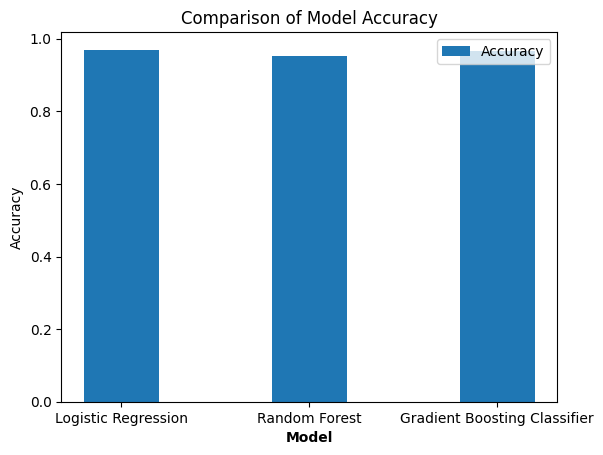

In [46]:
accuracies = [0.9696969696969697, 0.9523809523809523 , 0.9653679653679653]

labels = ['Logistic Regression', 'Random Forest' , 'Gradient Boosting Classifier']

x = np.arange(len(labels))

fig, ax = plt.subplots()

bar_width = 0.4

r1 = np.arange(len(accuracies))

ax.bar(r1, accuracies, width=bar_width, label='Accuracy')

ax.set_xlabel('Model', fontweight='bold')
ax.set_xticks([r for r in range(len(accuracies))])
ax.set_xticklabels(labels)
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracy')

ax.legend()
plt.show()